In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from scipy.stats import pearsonr as corr
import pickle
from tqdm import tqdm
import sys
from munkres import Munkres
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import gennorm
from typing import Union

from scipy.fft import dct

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

using cpu


In [2]:
# parameters
N = 16  # number of sparse sources
K = 3  # number of active components
M = 8  # number of measurements
seed = 20240625
num_data = 1024
lr = 3e-3
num_step = 20000
weight = 1e-2

In [3]:
def bound(N, K):
    return K * np.log10(N / K)

print('minimum M to solve problem', bound(N, K))

minimum M to solve problem 2.180996183808787


In [7]:
# helper
def sample_codes(S, S_):
    np.random.seed(seed)
    ind = np.random.choice(num_data, 9, replace=False)
    for j, i in enumerate(ind):
        plt.subplot(3, 3, j + 1)
        plt.plot(S[i], '.-')
        plt.plot(S_[i], '.-')
        plt.legend(['true', 'pred'])
    plt.tight_layout()
    plt.show()


def show_correlations(S, S_):
    plt.figure(figsize=(8, 8))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.scatter(S[:, i], S_[:, i], s=3)
        plt.grid()
        plt.title('c=%.4f' % corr(S[:, i], S_[:, i])[0])
        plt.xlabel('true')
        plt.ylabel('learned')
    plt.tight_layout()
    plt.show()


def find_permutation(S, S_):
    matches, indexes = match_latents(S, S_)
    S__ = np.zeros_like(S_)
    for i in range(N):
        S__[:, i] = S_[:, indexes[i][1]].copy()
    return S__


def sample_signal():
    s = np.random.normal(0, 1, N)
    s = np.abs(s)
    ind = np.random.choice(N, K, replace=False)
    mask = np.zeros(N)
    mask[ind] = 1
    s *= mask
    return s


def analyze(S, S_):
    # permute
    plt.imshow(match_latents(S, S_)[0])
    plt.colorbar()
    plt.xlabel('true')
    plt.ylabel('learned')
    plt.title('As Learned')
    plt.show()
    S_ = find_permutation(S, S_)
    plt.imshow(match_latents(S, S_)[0])
    plt.colorbar()
    plt.xlabel('true')
    plt.ylabel('learned')
    plt.title('Optimal Permutation')
    plt.show()
    # analyze
    sample_codes(S, S_)
    show_correlations(S, S_)


def criterion(S_, X, X_, weight=weight):
    loss = torch.sum((X - X_) ** 2) + weight * torch.sum(torch.abs(S_))
    return loss


# Evaluation metric
munk = Munkres()
def match_latents(z, z_):
    matches = np.zeros((z.shape[1], z_.shape[1]))
    for i in range(z.shape[1]):
        for j in range(z_.shape[1]):
            matches[i, j] = abs(corr(z[:, i], z_[:, j])[0])
    matches[np.isnan(matches)] = 0
    indexes = munk.compute(-matches)
    return matches, indexes


def eval_nd(z, z_):
    matches, indexes = match_latents(z, z_)
    corrs = []
    for i in indexes:
        corrs.append(matches[i[0], i[1]])
    return corrs


def mcc(z, z_):
    return np.mean(eval_nd(z, z_))

In [5]:
class SparseCoding(nn.Module):
    def __init__(self, S, D, learn_D, seed=seed):
        super().__init__()
        self.learn_D = learn_D
        torch.manual_seed(seed + 42)
        self.log_S_ = nn.Parameter(data=-10 * torch.ones(S.shape), requires_grad=True)
        if learn_D:
            self.D_ = nn.Parameter(data=torch.randn(D.shape), requires_grad=True)
        else:
            self.D_ = nn.Parameter(data=D, requires_grad=False)

    def forward(self, X=None):
        if self.learn_D:
            self.D_.data /= torch.linalg.norm(self.D_, dim=1, keepdim=True)
        S_ = torch.exp(self.log_S_)
        X_ = S_ @ self.D_
        return S_, X_


class Exp(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        return torch.exp(X)


class SparseAutoEncoder(nn.Module):
    def __init__(self, D, learn_D, seed=seed, relu=True):
        super().__init__()
        self.learn_D = learn_D
        torch.manual_seed(seed + 42)
        if relu:
            self.encoder = nn.Sequential(nn.Linear(M, N), nn.ReLU())
        else:
            self.encoder = nn.Sequential(nn.Linear(M, N), Exp())
        if learn_D:
            self.D_ = nn.Parameter(data=torch.randn(D.shape), requires_grad=True)
        else:
            self.D_ = nn.Parameter(data=D, requires_grad=False)

    def forward(self, X):
        if self.learn_D:
            self.D_.data /= torch.linalg.norm(self.D_, dim=1, keepdim=True)
        S_ = self.encoder(X)
        X_ = S_ @ self.D_
        return S_, X_


def train(model):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    for i in range(num_step):
        S_, X_ = model.forward(X)
        loss = criterion(S_, X, X_, weight=weight)
        optim.zero_grad()
        loss.backward()
        optim.step()
        if i > 0 and not i % 1000:
            # Print D_
            if not torch.all(S_.var(0) > 0):
                print('dead latents')
            print('step', i, 'loss', loss.item(),
                  'MCC', mcc(S, S_.detach().cpu().numpy()))
    S_ = S_.detach().cpu().numpy()
    print('final MCC', mcc(S, S_))
    return S_

In [6]:
# generate sample and move to torch
S = []
np.random.seed(seed)
for i in range(num_data):
    S.append(sample_signal())
S = np.array(S)
torch.manual_seed(seed)
D = torch.randn(N, M, dtype=torch.float32).to(device)
D /= torch.linalg.norm(D, dim=1, keepdim=True)
X = torch.tensor(S, dtype=torch.float32).to(device) @ D
print(S.shape, X.shape, D.shape)

(1024, 16) torch.Size([1024, 8]) torch.Size([16, 8])


## Sparse code, known dictionary

In [19]:
sc0 = SparseCoding(S, D, learn_D=False, seed=seed).to(device)
S_ = train(sc0)
# analyze(S, S_)

step 1000 loss 2900.755859375 MCC 0.27099487682191054
step 2000 loss 61.131675720214844 MCC 0.9038211107816947
step 3000 loss 36.01312255859375 MCC 0.9431548144374946
step 4000 loss 30.06017303466797 MCC 0.9670986752844125
step 5000 loss 27.88093376159668 MCC 0.9799464880722344
step 6000 loss 26.688621520996094 MCC 0.9863042807251424
step 7000 loss 25.95534896850586 MCC 0.9904184877333454
step 8000 loss 25.487638473510742 MCC 0.9936899286124776
step 9000 loss 25.17985725402832 MCC 0.9955541423450991
step 10000 loss 24.97623634338379 MCC 0.9975910018401071
step 11000 loss 24.85106658935547 MCC 0.9979424065034489
step 12000 loss 24.77254295349121 MCC 0.9980863677874503
step 13000 loss 24.72405242919922 MCC 0.9981836341102563
step 14000 loss 24.69402503967285 MCC 0.9982228007455624
step 15000 loss 24.675575256347656 MCC 0.9982324739305706
step 16000 loss 24.664522171020508 MCC 0.9982353689323646
step 17000 loss 24.657730102539062 MCC 0.9982369478349965
step 18000 loss 24.65350341796875 MC

## Sparse autoencoder, known dictionary

In [8]:
import sys
sys.path.append('..')

In [12]:
from models import MLP

mlp0 = MLP(D, projections_up=[M*8, N], learn_D=True, seed=seed)
S_ = train(mlp0)

MLP init - N: 16, M: 8
Projections: [64, 16]
D norm after setting: 11.7467622756958
D requires_grad: True
dead latents
step 1000 loss 50.440284729003906 MCC 0.48188538384577484


/var/folders/wg/cdt_cw_5265_z_gwnxlf0tv80000gn/T/ipykernel_76881/2685837302.py:76: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  matches[i, j] = abs(corr(z[:, i], z_[:, j])[0])


dead latents
step 2000 loss 40.69778060913086 MCC 0.5231377666286456
dead latents
step 3000 loss 36.20215606689453 MCC 0.5596154042251025
dead latents
step 4000 loss 34.6308708190918 MCC 0.574612098093608
dead latents
step 5000 loss 34.203121185302734 MCC 0.5847878670504114
dead latents
step 6000 loss 33.97262191772461 MCC 0.594276447365998
dead latents
step 7000 loss 33.82843017578125 MCC 0.6037289486336415
dead latents
step 8000 loss 33.82707214355469 MCC 0.608399005033371
dead latents
step 9000 loss 33.78446960449219 MCC 0.6141661150251563
dead latents
step 10000 loss 33.72505569458008 MCC 0.6169513951751543
dead latents
step 11000 loss 33.918060302734375 MCC 0.6191579185521012
dead latents
step 12000 loss 33.820716857910156 MCC 0.6198791986152149
dead latents
step 13000 loss 33.665122985839844 MCC 0.6197634871674694
dead latents
step 14000 loss 33.639137268066406 MCC 0.619671402741127
dead latents
step 15000 loss 33.613800048828125 MCC 0.6197152729243105
dead latents
step 16000 los

In [11]:
from models import MLP

mlp0 = MLP(D, projections_up=[M*8, N], learn_D=True, seed=seed+2)
S_ = train(mlp0)
# analyze(S, S_)

MLP init - N: 16, M: 8
Projections: [64, 16]
D norm after setting: 11.243287086486816
D requires_grad: True
dead latents
step 1000 loss 48.43470764160156 MCC 0.5436405516665881


/var/folders/wg/cdt_cw_5265_z_gwnxlf0tv80000gn/T/ipykernel_76881/2685837302.py:76: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  matches[i, j] = abs(corr(z[:, i], z_[:, j])[0])


dead latents
step 2000 loss 38.844688415527344 MCC 0.5935954881011662
dead latents
step 3000 loss 34.880584716796875 MCC 0.6279405297367272
dead latents
step 4000 loss 32.83175277709961 MCC 0.6352681393311557
dead latents
step 5000 loss 32.348419189453125 MCC 0.6391323921999751
dead latents
step 6000 loss 32.12025833129883 MCC 0.6435232698378508
dead latents
step 7000 loss 31.93581199645996 MCC 0.6454246697601671
dead latents
step 8000 loss 31.925745010375977 MCC 0.6458227196802986
dead latents
step 9000 loss 31.91991424560547 MCC 0.6490038079351744
dead latents
step 10000 loss 31.905818939208984 MCC 0.649079524955175
dead latents
step 11000 loss 31.91366958618164 MCC 0.6500079356872956
dead latents
step 12000 loss 31.8635196685791 MCC 0.6496252883641143
dead latents
step 13000 loss 31.897602081298828 MCC 0.6498545973469447
dead latents
step 14000 loss 31.968765258789062 MCC 0.6498473305072349
dead latents
step 15000 loss 31.998619079589844 MCC 0.6503268118186513
dead latents
step 1600

dead latents
step 1000 loss 169.45278930664062 MCC 0.5420689821844185


/var/folders/wg/cdt_cw_5265_z_gwnxlf0tv80000gn/T/ipykernel_72006/3112556569.py:76: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  matches[i, j] = abs(corr(z[:, i], z_[:, j])[0])


dead latents
step 2000 loss 121.31918334960938 MCC 0.5953934353652677
dead latents
step 3000 loss 119.53885650634766 MCC 0.5972887794574949
dead latents
step 4000 loss 119.24898529052734 MCC 0.5891914956742272
dead latents
step 5000 loss 119.17853546142578 MCC 0.5850688030752258
dead latents
step 6000 loss 119.13282775878906 MCC 0.5852885914712069
dead latents
step 7000 loss 119.13358306884766 MCC 0.5850776296517695
dead latents
step 8000 loss 119.13386535644531 MCC 0.5851422543166155
dead latents
step 9000 loss 119.13356018066406 MCC 0.5850492914246186
dead latents
step 10000 loss 119.13468933105469 MCC 0.5850511696267581
dead latents
step 11000 loss 119.13365173339844 MCC 0.5851079503586349
dead latents
step 12000 loss 119.1339111328125 MCC 0.585004691573405
dead latents
step 13000 loss 119.13399505615234 MCC 0.5850820894179916
dead latents
step 14000 loss 119.13577270507812 MCC 0.5850831432747675
dead latents
step 15000 loss 119.13440704345703 MCC 0.5851211131455928
dead latents
ste

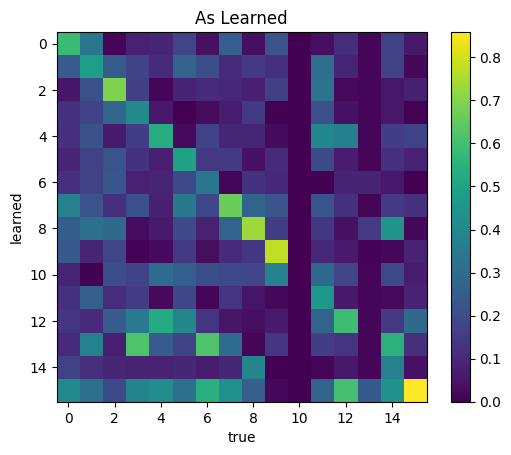

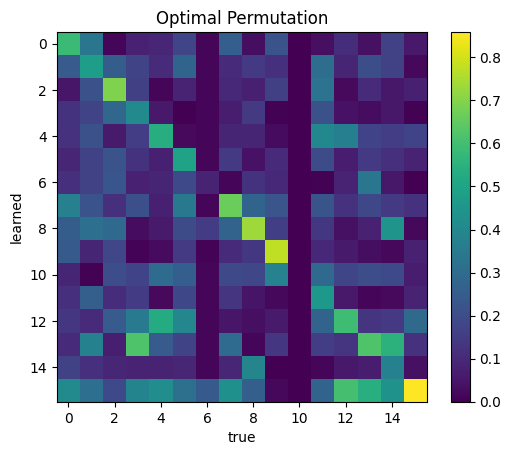

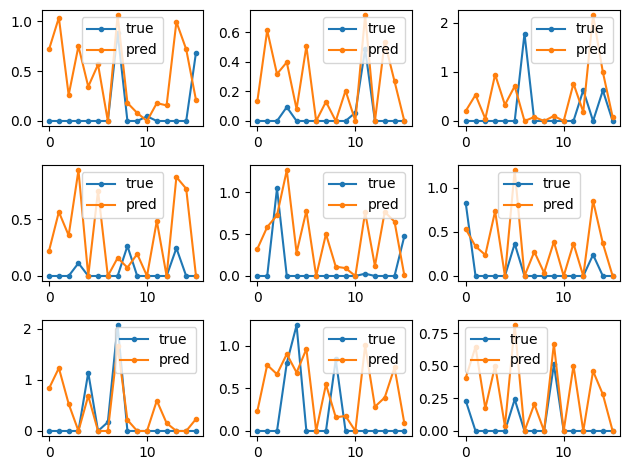

/var/folders/wg/cdt_cw_5265_z_gwnxlf0tv80000gn/T/ipykernel_72006/3112556569.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  plt.title('c=%.4f' % corr(S[:, i], S_[:, i])[0])


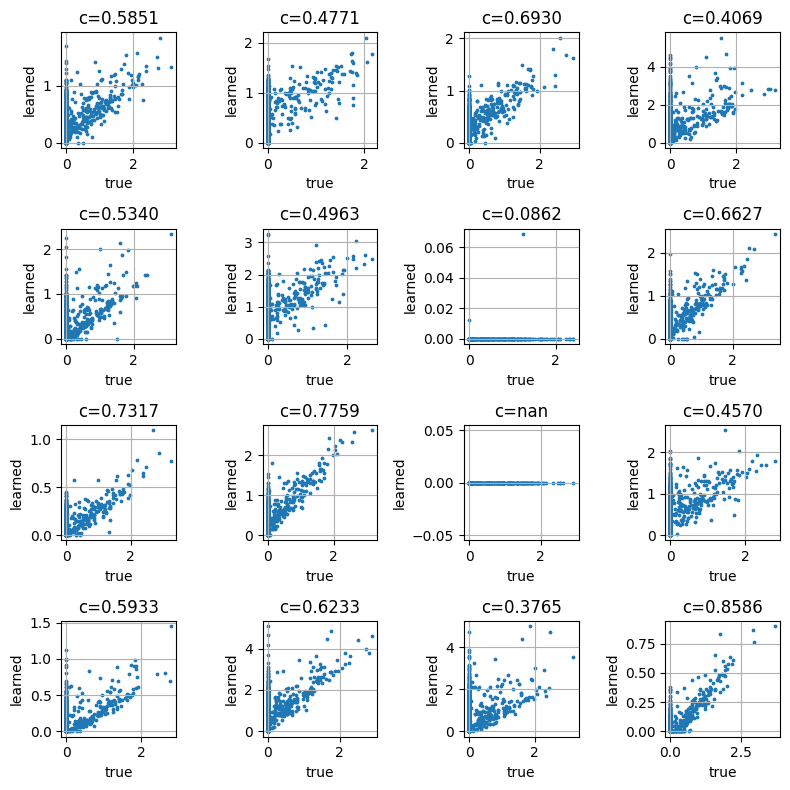

In [15]:
sae0 = SparseAutoEncoder(D, learn_D=False, seed=seed, relu=True).to(device)
S_ = train(sae0)
analyze(S, S_)

## Sparse coding, learning dictionary

step 1000 loss 2802.861328125 MCC 0.44692627353612313
step 2000 loss 190.0848388671875 MCC 0.7884879163620739
step 3000 loss 56.455055236816406 MCC 0.6840620576752856
step 4000 loss 40.4018669128418 MCC 0.7022185752485519
step 5000 loss 36.01589584350586 MCC 0.7603060655991399
step 6000 loss 33.72260665893555 MCC 0.8332903717294531
step 7000 loss 32.406097412109375 MCC 0.8782570703123871
step 8000 loss 31.444454193115234 MCC 0.9044704600663258
step 9000 loss 30.432964324951172 MCC 0.9106566462727823
step 10000 loss 29.928281784057617 MCC 0.9127237258016507
step 11000 loss 29.95750617980957 MCC 0.9064039285620016
step 12000 loss 30.395172119140625 MCC 0.9023476455992463
step 13000 loss 30.903287887573242 MCC 0.8827967783977304
step 14000 loss 31.8712100982666 MCC 0.7596269763283523
step 15000 loss 32.76664733886719 MCC 0.7432163460339449
step 16000 loss 32.20016860961914 MCC 0.7875955303226061
step 17000 loss 32.16244888305664 MCC 0.812685163272941
step 18000 loss 32.426448822021484 MCC

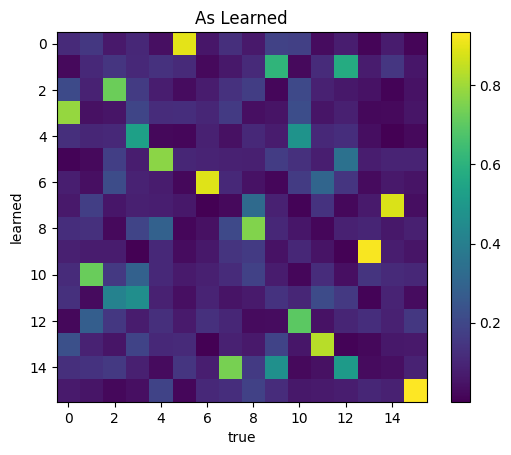

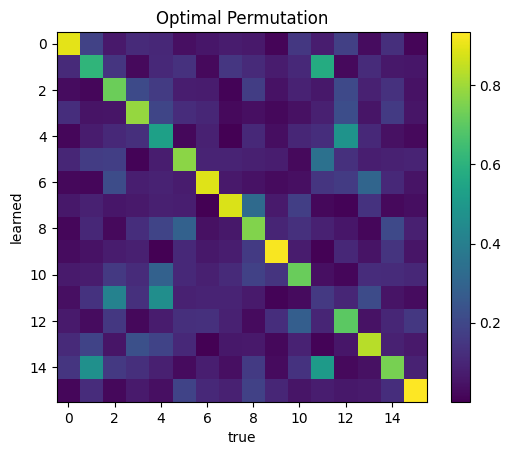

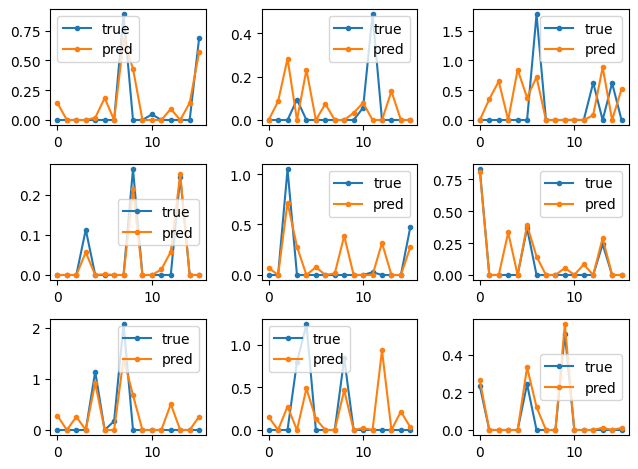

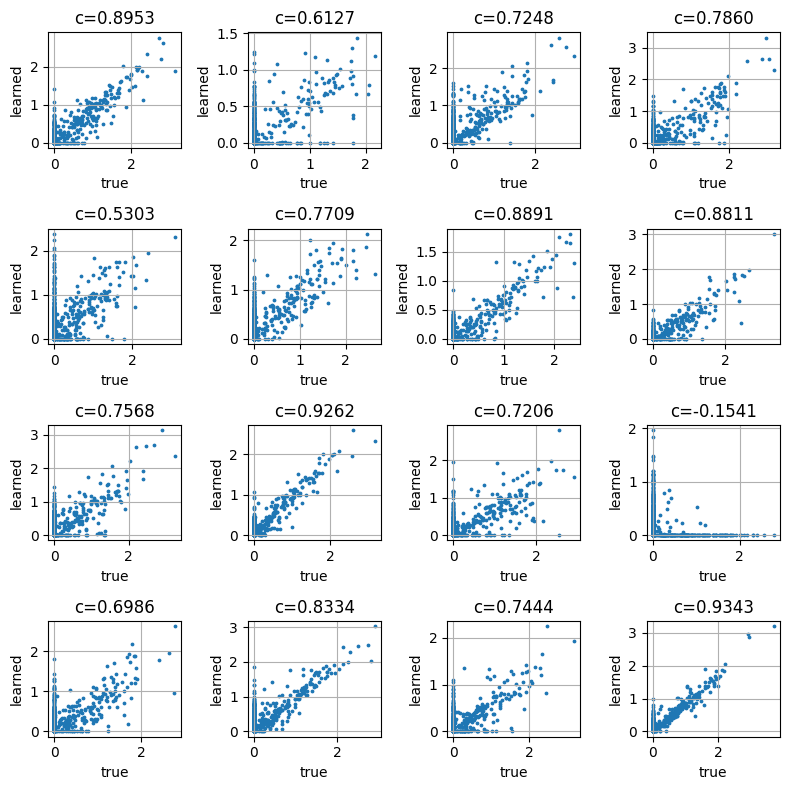

In [13]:
sc1 = SparseCoding(S, D, learn_D=True, seed=seed).to(device)
S_ = train(sc1)
analyze(S, S_)

## Sparse autoencoder, learning dictionary

step 1000 loss 200.42056274414062 MCC 0.6858140732629139
step 2000 loss 167.4375 MCC 0.4816326853872106
step 3000 loss 144.28041076660156 MCC 0.5015268901649161
step 4000 loss 128.1123504638672 MCC 0.7268936561425091
step 5000 loss 117.89173889160156 MCC 0.7369586328671494
step 6000 loss 115.10596466064453 MCC 0.7181525309140797
step 7000 loss 112.9382553100586 MCC 0.691669537175608
step 8000 loss 110.4206314086914 MCC 0.6166290908382845
step 9000 loss 109.93016052246094 MCC 0.4805933443788991
step 10000 loss 109.6013412475586 MCC 0.5908615060556821
step 11000 loss 109.79910278320312 MCC 0.4358979459926098
step 12000 loss 109.2861328125 MCC 0.403952798368286
step 13000 loss 107.87928771972656 MCC 0.4653050277207602
step 14000 loss 110.75048065185547 MCC 0.3862787428215929
step 15000 loss 111.33917999267578 MCC 0.4784845870254233
step 16000 loss 109.50566864013672 MCC 0.43208267463424554
step 17000 loss 109.45870971679688 MCC 0.43096285110452026
step 18000 loss 111.23261260986328 MCC 0.

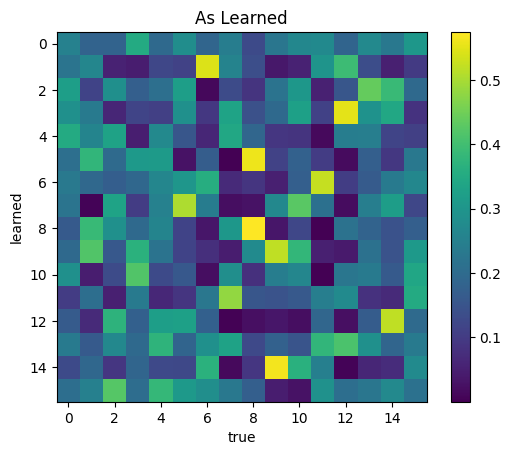

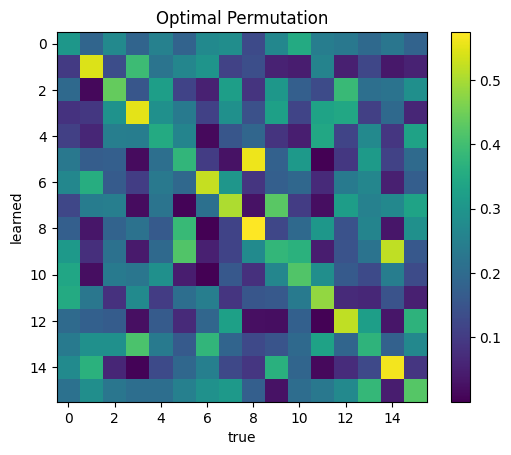

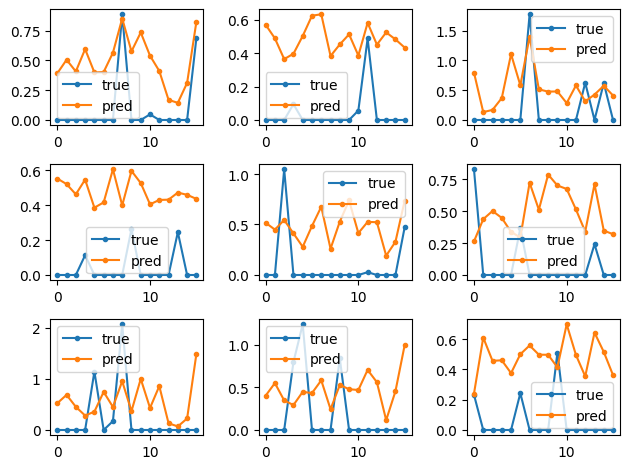

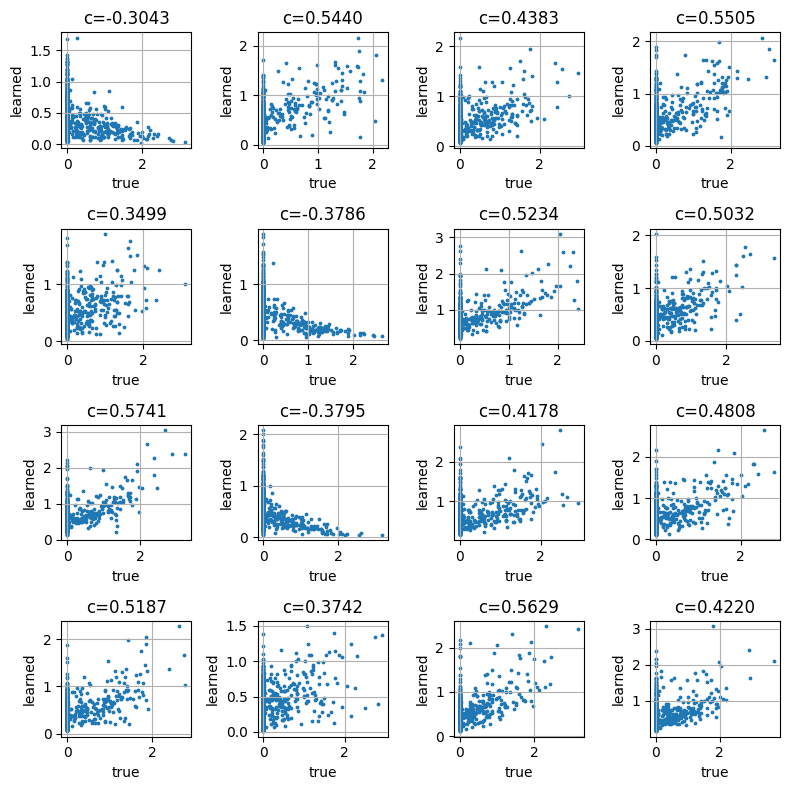

In [12]:
sae1 = SparseAutoEncoder(D, learn_D=True, seed=seed, relu=False,).to(device)
S_ = train(sae1)
analyze(S, S_)

## Scikit-Learn

In [23]:
import numpy as np
from sklearn.datasets import make_sparse_coded_signal
from sklearn.decomposition import DictionaryLearning
X, dictionary, code = make_sparse_coded_signal(
    n_samples=30, n_components=15, n_features=20, n_nonzero_coefs=10,
    random_state=42,
)

In [17]:
X.shape # B, M

(30, 20)

In [20]:
dictionary.shape # N, M

(15, 20)

In [22]:
code.shape # B, N

(30, 15)

## 